In [91]:
import re
import string
import joblib

import numpy as np
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, make_scorer, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline

In [30]:
lemmatizer = WordNetLemmatizer()

In [2]:
df = pd.read_csv('training_data/training_data_29032022.csv')

df.shape

(149823, 4)

In [3]:
df.head()

,merchant_category,processed_text,storefront_uuid,text
0,restaurant,menu chicken steak menu menu chicken tikka str...,000030df-b29b-444c-b77a-5f48107a6cf5,Menu chicken steak Menus Menu chicken tikka st...
1,restaurant,when larry met shrimpy combo popular loner clu...,00008ea3-e75b-4219-80e9-498afb0fef3e,When Larry Met Shrimpy Combos Popular Loner (C...
2,restaurant,gajar halwa milkshake drink tawa plain roti si...,00014217-285f-4b5f-9781-f62dc921c8ea,Gajar Halwa - Milkshake Drinks Tawa Plain Roti...
3,restaurant,avocado side order huevos rancheros bountiful ...,0001439d-b61b-49b5-be9d-6004d6178ce1,Avocado Side Order Huevos Rancheros Bountiful ...
4,restaurant,soy and garlic fried chicken fried chicken bon...,00022afa-395e-41f5-86a7-0a66b6891ea6,Soy and Garlic Fried Chicken Fried Chicken Bon...


In [11]:
df['merchant_category'].value_counts()

restaurant      4747
gse             3731
alcohol         3550
flower           208
pet supplies      85
retail            75
pharmacy          74
Name: merchant_category, dtype: int64

In [6]:
df_temp = df[df['merchant_category']!='restaurant']
df_temp2 = df.sample(n=5000)

df = pd.concat([df_temp, df_temp2])

df.shape

(12470, 4)

In [42]:
validation_data = pd.read_csv('training_data/validation_data.csv')

validation_data.shape

(29965, 6)

In [43]:
new_df = df.merge(validation_data, how='left', on=['merchant_category','storefront_uuid','processed_text','text']).drop_duplicates(keep=False)

new_df.shape

(11924, 6)

In [44]:
new_df['merchant_category'].value_counts()

restaurant      4737
gse             3475
alcohol         3298
flower           194
pet supplies      83
retail            71
pharmacy          66
Name: merchant_category, dtype: int64

In [76]:
4737*100/len(new_df)

39.72660181147266

In [12]:
randomforest_mer = Pipeline([('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer()),
                            ('clf', RandomForestClassifier(class_weight='balanced', random_state=1))])

In [16]:
randomforest_mer.fit(new_df['processed_text'], new_df['merchant_category'])

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=1))])

In [45]:
validation_data.head()

,merchant_category,processed_text,storefront_uuid,text,y_hat,confidence_score
0,restaurant,sausage egg potato taco pc breakfast taco oran...,37191f20-b02f-4701-889f-5808385cc338,Sausage Egg Potato Taco (3 pcs) Breakfast Taco...,restaurant,0.99
1,restaurant,biologische culinaire saus curcu biologische c...,2b37312b-04d9-4dd8-9556-c5e4c054858f,Biologische culinaire saus Curcu Biologische c...,restaurant,0.98
2,restaurant,hot dog refris ml combo hot dog sugest o da ca...,788a3bb8-df6d-47ed-855f-304d96118a54,4 HOT DOG'S + 2 REFRIS 600ML COMBOS Hot dog su...,restaurant,0.94
3,restaurant,n n n n n n n n n n n n n n n n n n n n,003ee9f3-908b-4e59-8d40-23783ff50c7d,烏龍麵 單點 麻辣四寶套餐 人氣精選 麻辣雙寶 \N 空心菜 \N 鑫鑫腸 單點 麻辣鴨血套...,restaurant,0.74
4,restaurant,iced lemon spring tea fruit tea a ice slurp ir...,68697f93-78de-476e-b190-23eeca55d978,檸檬青茶 Iced Lemon Spring Tea 水果茶 Fruit Tea （新品上市...,restaurant,0.97


In [46]:
validation_data['y_hat'] = randomforest_mer.predict(validation_data['processed_text'])
validation_data['confidence_score'] = np.round_(np.max(randomforest_mer.predict_proba(validation_data['processed_text']), axis=1), decimals=2)

In [47]:
print(classification_report(validation_data['merchant_category'], validation_data['y_hat']))

              precision    recall  f1-score   support

     alcohol       0.94      1.00      0.97       698
      flower       1.00      1.00      1.00        34
         gse       0.26      0.97      0.41       710
pet supplies       1.00      0.95      0.97        20
    pharmacy       1.00      1.00      1.00        15
  restaurant       1.00      0.93      0.96     28472
      retail       0.94      1.00      0.97        16

    accuracy                           0.93     29965
   macro avg       0.88      0.98      0.90     29965
weighted avg       0.98      0.93      0.95     29965



In [51]:
sample = validation_data[(validation_data['merchant_category']!='restaurant') & (validation_data['merchant_category_undersampling']=='restaurant')]

In [52]:
sample['merchant_category'].value_counts()

gse             15
pet supplies     1
Name: merchant_category, dtype: int64

In [23]:
1-1/20

0.95

In [40]:
validation_data.head()

,merchant_category,storefront_uuid,merchant_category_undersampling,confidence_score_undersampling
0,restaurant,37191f20-b02f-4701-889f-5808385cc338,restaurant,0.85
1,restaurant,2b37312b-04d9-4dd8-9556-c5e4c054858f,restaurant,0.78
2,restaurant,788a3bb8-df6d-47ed-855f-304d96118a54,restaurant,0.77
3,restaurant,003ee9f3-908b-4e59-8d40-23783ff50c7d,restaurant,0.71
4,restaurant,68697f93-78de-476e-b190-23eeca55d978,gse,0.56


In [48]:
# validation_data.drop(['text', 'processed_text'], axis=1, inplace=True)

validation_data = validation_data.rename(columns={'y_hat': 'merchant_category_undersampling', 'confidence_score': 'confidence_score_undersampling'})

In [49]:
validation_data.to_csv('output/validation_output_undersampling.csv', index=False)

## Production Test Data

In [24]:
test_data = pd.read_csv('test_data/test_data_by_query.csv')

test_data.shape

(1000000, 8)

In [25]:
test_data.head()

,storefront_uuid,parent_chain_or_store_name,merchant_type_analytics,segment,country_name,location_type,menu_item,menu_items_subsection_name
0,07ec9a4f-b71d-4277-a0a6-239214c2bfa8,derrick snacks & deli [smb parent],MERCHANT_TYPE_ESSENTIALS,SMB - Outbound,Canada,GROCERY_STORE,Ferrero Rocher,Candies and Chocolate Bars
1,07ec9a4f-b71d-4277-a0a6-239214c2bfa8,derrick snacks & deli [smb parent],MERCHANT_TYPE_ESSENTIALS,SMB - Outbound,Canada,GROCERY_STORE,Ham and Cheese Sandwiches,Sandwiches
2,07ec9a4f-b71d-4277-a0a6-239214c2bfa8,derrick snacks & deli [smb parent],MERCHANT_TYPE_ESSENTIALS,SMB - Outbound,Canada,GROCERY_STORE,Clubhouse Sandwiches,Sandwiches
3,07ec9a4f-b71d-4277-a0a6-239214c2bfa8,derrick snacks & deli [smb parent],MERCHANT_TYPE_ESSENTIALS,SMB - Outbound,Canada,GROCERY_STORE,Canadian Vegetable Samosas,Samosas
4,07ec9a4f-b71d-4277-a0a6-239214c2bfa8,derrick snacks & deli [smb parent],MERCHANT_TYPE_ESSENTIALS,SMB - Outbound,Canada,GROCERY_STORE,Big Dutch Crunch,Chips


In [27]:
def preprocess_text(message):
    # To handle np.nan 
    if isinstance(message, float):
        return None
    
    #lowering and removing punctuation
    message = re.sub(r'[^\w\s]','', message.lower())
    
    #removing the numerical values and working only with text values
    message = re.sub('[^a-zA-Z]', " ", message )
    
    #lemmatizing the text
    message =  " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(message) if w not in string.punctuation])
    
    # after preprocessing if message is empty string 
    if not message:
        message = None
        
    return message

In [28]:
def prepare_data(data):
    # apply preprocessing steps
    # data['mer_name'] = data['parent_chain_or_store_name'].apply(preprocess_text)
    unique_mer = data['parent_chain_or_store_name'].unique()
    unique_mer = [i for i in unique_mer if preprocess_text(i)]
    
    data = data[data['parent_chain_or_store_name'].isin(unique_mer)]
    
    # print(data.shape)

    # remove where merchant name is NULL (Asian)
    # data = data.dropna(how='any', subset=['mer_name'])
    
    # remove rows where merchant type is unknown
    data = data[data['merchant_type_analytics']!='MERCHANT_TYPE_UNKNOWN']
    
    # prepare output variable
    data['merchant_category'] = data['merchant_type_analytics'].str.replace('MERCHANT_TYPE_LIQUOR', 'alcohol').str.replace('MERCHANT_TYPE_ESSENTIALS', 'gse')\
    .str.replace('MERCHANT_TYPE_SPECIALTY_FOOD', 'gse').str.replace('MERCHANT_TYPE_GROCERY', 'gse')\
    .str.replace('MERCHANT_TYPE_PHARMACY', 'pharmacy').str.replace('MERCHANT_TYPE_PET_SUPPLY', 'pet supplies')\
    .str.replace('MERCHANT_TYPE_RETAIL', 'retail').str.replace('MERCHANT_TYPE_FLOWER', 'flower').str.replace('MERCHANT_TYPE_RESTAURANT', 'restaurant')
    
    # concatenate features into single corpus
    data['text'] = data['menu_item'].astype('str') + " " + data['menu_items_subsection_name'].astype('str')
    
    # groupby on storefront_uuid to prepare training data
    data = data.groupby(['storefront_uuid', 'merchant_category'], as_index = False).agg({'text': ' '.join})
    
    # preprocessing steps for text data
    data['processed_text'] = data['text'].apply(preprocess_text)
    
    # drop rows which became NULL after preprocessing
    data = data.dropna(how='any')
    
    return data

In [31]:
test_data = prepare_data(test_data)
test_data.head()

,storefront_uuid,merchant_category,text,processed_text
0,0001439d-b61b-49b5-be9d-6004d6178ce1,restaurant,Cocktail Sauce Condiments and Sauces Egg Side ...,cocktail sauce condiment and sauce egg side or...
1,0018b366-7921-418f-acc0-8316734901ec,restaurant,Chiles Rellenos Entrees Mole Enchiladas Enchil...,chile rellenos entree mole enchilada enchilada...
2,001a94d0-5f1b-4404-bb82-fa5e7c2318f5,restaurant,(1 lb) Selva Negra Light Roast Coffee Bulk Cof...,lb selva negra light roast coffee bulk coffee ...
3,0022c4d7-32a4-4f45-a7e6-38202882640d,restaurant,Toast Sides and Drinks Gatorade Sides and Drin...,toast side and drink gatorade side and drink s...
4,002474a7-e249-43a6-84cf-f6e987cb09f5,restaurant,Diet Coke® Beverages Spring Roll (Four Pieces)...,diet coke beverage spring roll four piece appe...


In [33]:
test_data['y_hat'] = randomforest_mer.predict(test_data['processed_text'])
test_data['confidence_score'] = np.round_(np.max(randomforest_mer.predict_proba(test_data['processed_text']), axis=1), decimals=2)

In [34]:
test_data.head()

,storefront_uuid,merchant_category,text,processed_text,y_hat,confidence_score
0,0001439d-b61b-49b5-be9d-6004d6178ce1,restaurant,Cocktail Sauce Condiments and Sauces Egg Side ...,cocktail sauce condiment and sauce egg side or...,restaurant,0.94
1,0018b366-7921-418f-acc0-8316734901ec,restaurant,Chiles Rellenos Entrees Mole Enchiladas Enchil...,chile rellenos entree mole enchilada enchilada...,restaurant,0.92
2,001a94d0-5f1b-4404-bb82-fa5e7c2318f5,restaurant,(1 lb) Selva Negra Light Roast Coffee Bulk Cof...,lb selva negra light roast coffee bulk coffee ...,restaurant,0.54
3,0022c4d7-32a4-4f45-a7e6-38202882640d,restaurant,Toast Sides and Drinks Gatorade Sides and Drin...,toast side and drink gatorade side and drink s...,restaurant,0.77
4,002474a7-e249-43a6-84cf-f6e987cb09f5,restaurant,Diet Coke® Beverages Spring Roll (Four Pieces)...,diet coke beverage spring roll four piece appe...,restaurant,0.98


In [35]:
print(classification_report(test_data['merchant_category'], test_data['y_hat']))

              precision    recall  f1-score   support

     alcohol       0.96      1.00      0.98       165
      flower       1.00      1.00      1.00         8
         gse       0.16      0.97      0.27       118
pet supplies       1.00      1.00      1.00         5
    pharmacy       1.00      1.00      1.00         1
  restaurant       1.00      0.94      0.97     10300
      retail       1.00      0.80      0.89         5

    accuracy                           0.94     10602
   macro avg       0.87      0.96      0.87     10602
weighted avg       0.99      0.94      0.96     10602



In [36]:
test_data.to_csv('output/test_output_undersampling.csv', index=False)

In [ ]:
sample = validation_data[(validation_data['merchant_category']!='restaurant') & (validation_data['y_hat']=='restaurant')]

## Production Data

In [53]:
prod_data = pd.read_csv('test_data/production_tagged_data.csv')

prod_data.shape

(396142, 5)

In [54]:
prod_data.head()

,storefront_uuid,merchant_category_by_gss,merchant_type_analytics,text,processed_text
0,000030df-b29b-444c-b77a-5f48107a6cf5,Restaurants,restaurant,Menu fish fillet Menus Mozzarella sticks Tex-M...,menu fish fillet menu mozzarella stick texmex ...
1,00003271-e3c2-4467-94ab-4f3019845cf4,Restaurants,restaurant,Oasis pomme cassis framboise Boissons Pizza vé...,oasis pomme cassis framboise boissons pizza v ...
2,00004348-fb7f-480a-84ca-9a1a7247ee60,Restaurants,MERCHANT_TYPE_UNKNOWN,Beef Chop Suey Chop Suey Salmon Nigri Nigiri E...,beef chop suey chop suey salmon nigri nigiri e...
3,00008ea3-e75b-4219-80e9-498afb0fef3e,Restaurants,restaurant,When Larry Met Crabby Combos Crab tool Sides P...,when larry met crabby combo crab tool side pop...
4,00008eb9-0abe-4277-bb44-8bbc6c6a576f,Restaurants,restaurant,Refrigerantes 350ml Bebidas Açaí 400ml com adi...,refrigerantes ml bebidas a a ml com adicionais...


In [56]:
prod_data['y_hat'] = randomforest_mer.predict(prod_data['processed_text'])
prod_data['confidence_score'] = np.round_(np.max(randomforest_mer.predict_proba(prod_data['processed_text']), axis=1), decimals=2)

In [62]:
print(classification_report(prod_data['merchant_category_by_gss'], prod_data['y_hat']))

              precision    recall  f1-score   support

     alcohol       0.82      0.97      0.89      4036
      flower       0.99      0.94      0.96       142
         gse       0.14      0.89      0.25      5648
pet supplies       1.00      0.89      0.94        63
    pharmacy       0.98      0.89      0.93        63
  restaurant       1.00      0.92      0.96    386130
      retail       0.91      0.72      0.80        60

    accuracy                           0.92    396142
   macro avg       0.84      0.89      0.82    396142
weighted avg       0.98      0.92      0.95    396142



In [65]:
prod_data['merchant_category_by_gss'].value_counts()

restaurant      386130
gse               5648
alcohol           4036
flower             142
pharmacy            63
pet supplies        63
retail              60
Name: merchant_category_by_gss, dtype: int64

In [66]:
prod_data['merchant_type_analytics'].value_counts()

restaurant               367052
MERCHANT_TYPE_UNKNOWN     21200
alcohol                    3937
gse                        3636
flower                      137
retail                       64
pharmacy                     59
pet supplies                 57
Name: merchant_type_analytics, dtype: int64

In [61]:
prod_data['merchant_category_by_gss'] = prod_data['merchant_category_by_gss'].str.replace('Restaurants', 'restaurant')\
                                        .str.replace('Essentials', 'gse').str.replace('Flowers', 'flower')\
                                        .str.replace('Grocery', 'gse').str.replace('Liquor Store', 'alcohol')\
                                        .str.replace('Pet Supplies', 'pet supplies').str.replace('Pharmacy', 'pharmacy')\
                                        .str.replace('Retail', 'retail').str.replace('Speciality foods', 'gse')

In [64]:
mask1 = (prod_data['merchant_category_by_gss']=='restaurant') & (prod_data['y_hat']!='restaurant')
mask2 = (prod_data['merchant_category_by_gss']!='restaurant') & (prod_data['y_hat']=='restaurant')


prod_data['diff_merchant_category_by_gss'] = np.select([mask1, mask2], ['restaurant predicted as non-restaurant', 'non-restaurant predicted as restaurant'], '')


In [67]:
mask1 = (prod_data['merchant_type_analytics']=='restaurant') & (prod_data['y_hat']!='restaurant')
mask2 = (prod_data['merchant_type_analytics']!='restaurant') & (prod_data['y_hat']=='restaurant')


prod_data['diff_merchant_type_analytics'] = np.select([mask1, mask2], ['restaurant predicted as non-restaurant', 'non-restaurant predicted as restaurant'], '')


In [71]:
prod_data.drop(['text','processed_text'], axis=1, inplace=True)

In [72]:
prod_data.to_csv('output/prod_data_tagged.csv', index=False)

In [70]:
prod_data.head()

,storefront_uuid,merchant_category_by_gss,merchant_type_analytics,text,processed_text,y_hat,confidence_score,diff_merchant_category_by_gss,diff_merchant_type_analytics
0,000030df-b29b-444c-b77a-5f48107a6cf5,restaurant,restaurant,Menu fish fillet Menus Mozzarella sticks Tex-M...,menu fish fillet menu mozzarella stick texmex ...,restaurant,0.94,,
1,00003271-e3c2-4467-94ab-4f3019845cf4,restaurant,restaurant,Oasis pomme cassis framboise Boissons Pizza vé...,oasis pomme cassis framboise boissons pizza v ...,restaurant,0.81,,
2,00004348-fb7f-480a-84ca-9a1a7247ee60,restaurant,MERCHANT_TYPE_UNKNOWN,Beef Chop Suey Chop Suey Salmon Nigri Nigiri E...,beef chop suey chop suey salmon nigri nigiri e...,restaurant,0.92,,non-restaurant predicted as restaurant
3,00008ea3-e75b-4219-80e9-498afb0fef3e,restaurant,restaurant,When Larry Met Crabby Combos Crab tool Sides P...,when larry met crabby combo crab tool side pop...,restaurant,0.63,,
4,00008eb9-0abe-4277-bb44-8bbc6c6a576f,restaurant,restaurant,Refrigerantes 350ml Bebidas Açaí 400ml com adi...,refrigerantes ml bebidas a a ml com adicionais...,restaurant,0.71,,


In [73]:
samples = prod_data[(prod_data['merchant_category_by_gss']!='restaurant') & (prod_data['y_hat']=='restaurant')]

In [74]:
samples['merchant_category_by_gss'].value_counts()

gse             393
alcohol          20
retail            5
pet supplies      3
flower            3
Name: merchant_category_by_gss, dtype: int64

In [98]:
joblib.dump(randomforest_mer, "model_folder/merchants_model_undersampling_04142022.joblib")

['model_folder/merchants_model_undersampling_04142022.joblib']

## Restraurants vs New Vertical

In [77]:
dfy = pd.read_csv('output/prod_data_tagged.csv')

In [78]:
dfy.head()

,storefront_uuid,merchant_category_by_gss,merchant_type_analytics,y_hat,confidence_score,diff_merchant_category_by_gss,diff_merchant_type_analytics
0,000030df-b29b-444c-b77a-5f48107a6cf5,restaurant,restaurant,restaurant,0.94,NaN,NaN
1,00003271-e3c2-4467-94ab-4f3019845cf4,restaurant,restaurant,restaurant,0.81,NaN,NaN
2,00004348-fb7f-480a-84ca-9a1a7247ee60,restaurant,MERCHANT_TYPE_UNKNOWN,restaurant,0.92,NaN,non-restaurant predicted as restaurant
3,00008ea3-e75b-4219-80e9-498afb0fef3e,restaurant,restaurant,restaurant,0.63,NaN,NaN
4,00008eb9-0abe-4277-bb44-8bbc6c6a576f,restaurant,restaurant,restaurant,0.71,NaN,NaN


In [79]:
dfy['merchant_category_new'] = np.where(dfy['merchant_category_by_gss']=='restaurant', 'restaurant', 'new_vertical')

dfy['y_hat_new'] = np.where(dfy['y_hat']=='restaurant', 'restaurant', 'new_vertical')

In [94]:
cm = confusion_matrix(dfy['merchant_category_new'] , dfy['y_hat_new'])
print(cm)

[[  9588    424]
 [ 30021 356109]]


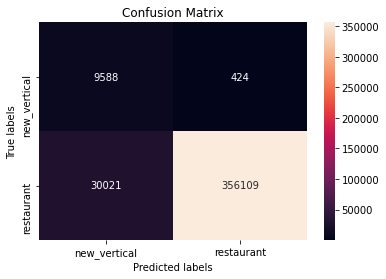

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['new_vertical', 'restaurant'])
ax.yaxis.set_ticklabels(['new_vertical', 'restaurant'])
plt.show()

In [3]:
import joblib
randomforest_mer = joblib.load('model_folder/merchants_model_undersampling_04142022.joblib')

joblib.dump(randomforest_mer, 'model_folder/merchants.pkl')

['model_folder/merchants.pkl']